In [1]:
pwd

'C:\\Users\\Anneth\\Documents\\GitHub\\Thesis-2025\\replicate_experiment'

In [12]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from accelerate.test_utils.testing import get_backend

device, _, _ = get_backend() # automatically detects the underlying device type (CUDA, CPU, XPU, MPS, etc.)
model_id = "./pretrained_gpt2"
finetuned_model_path = "./finetuned_gpt2_black"
model = GPT2LMHeadModel.from_pretrained(model_id).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)

In [13]:
from datasets import load_dataset

test = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
encodings = tokenizer("\n\n".join(test["text"]), return_tensors="pt")

Using the latest cached version of the dataset since wikitext couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'wikitext-2-raw-v1' at C:\Users\Anneth\.cache\huggingface\datasets\wikitext\wikitext-2-raw-v1\0.0.0\b08601e04326c79dfdd32d625aee71d232d685c3 (last modified on Wed Apr  9 15:04:05 2025).
Token indices sequence length is longer than the specified maximum sequence length for this model (287644 > 1024). Running this sequence through the model will result in indexing errors


In [14]:
import torch
from tqdm import tqdm
import numpy as np
from detoxify import Detoxify
import gc
from copy import deepcopy
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load tokenizer and fix padding
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Required for some models


In [15]:
def normalize_weights(param_diff, eps=1e-6):
    norm = torch.norm(param_diff)
    return param_diff / (norm + eps)    
    
# Task Vector Class
class TaskVector:
    def __init__(self, pretrained_checkpoint, finetuned_checkpoint):
        # Keep models on CPU initially
        self.pretrained_model = AutoModelForCausalLM.from_pretrained(model_id).cpu()
        self.finetuned_model = AutoModelForCausalLM.from_pretrained(finetuned_model_path).cpu()

    def __neg__(self):
        neg_vector = TaskVector.__new__(TaskVector)
        neg_vector.pretrained_model = self.pretrained_model
        neg_vector.finetuned_model = self.finetuned_model
        for p_pre, p_fine in zip(
            neg_vector.pretrained_model.parameters(), neg_vector.finetuned_model.parameters()
        ):
            p_fine.data = p_pre.data - p_fine.data
        return neg_vector

    def apply_to(self, base_model, scaling_coef):
        # Move only temporarily
        self.pretrained_model.to(device)
        self.finetuned_model.to(device)
        base_model = base_model.to(device)
    
        for p_base, p_pre, p_fine in zip(
            base_model.parameters(),
            self.pretrained_model.parameters(),
            self.finetuned_model.parameters(),
        ):
            p_base.data += scaling_coef * normalize_weights(p_fine.data - p_pre.data)

        # Clear memory here for better memory management
        self.pretrained_model.to("cpu")
        self.finetuned_model.to("cpu")
        torch.cuda.empty_cache()

        return base_model

In [16]:
# Initialize Task Vectors
task_vector = TaskVector(model_id, finetuned_model_path)

# Scaling coefficients
scaling_factors = np.arange(-1.0, 1.1, 0.1)

In [17]:
prompt = "You're a real" 

In [18]:
import torch
from tqdm import tqdm

def calculate_perplexity(model, tokenizer, encodings, device):
    max_length = model.config.n_positions
    stride = 512
    seq_len = encodings.input_ids.size(1)
    
    nll_sum = 0.0
    n_tokens = 0
    prev_end_loc = 0
    for begin_loc in tqdm(range(0, seq_len, stride)):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100
    
        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
    
            # loss is calculated using CrossEntropyLoss which averages over valid labels
            # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
            # to the left by 1.
            neg_log_likelihood = outputs.loss
    
        # Accumulate the total negative log-likelihood and the total number of tokens
        num_valid_tokens = (target_ids != -100).sum().item()  # number of valid tokens in target_ids
        batch_size = target_ids.size(0)
        num_loss_tokens = num_valid_tokens - batch_size  # subtract batch_size due to internal label shift
        nll_sum += neg_log_likelihood * num_loss_tokens
        n_tokens += num_loss_tokens
    
        prev_end_loc = end_loc
        if end_loc == seq_len:
            break
    
    avg_nll = nll_sum / n_tokens  # average negative log-likelihood per token
    ppl = torch.exp(avg_nll)
    print(f"Perplexity: {ppl.item():.2f}")
    return ppl.item()

In [19]:
# Generation function
def generate_text(model, tokenizer, prompt, num_samples=1000, max_new_tokens=100, device='cuda'):
    model.eval()
    model.to(device)
    samples = []

    for _ in range(num_samples):
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        inputs['pad_token_id'] = tokenizer.pad_token_id

        with torch.no_grad():
            output = model.generate(
                inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                pad_token_id=inputs['pad_token_id'],
                max_new_tokens=max_new_tokens,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=1.0,
            )
        text = tokenizer.decode(output[0], skip_special_tokens=True)
        samples.append(text)

    return samples

In [21]:
"""vector ppl"""
from copy import deepcopy
import pandas as pd

# Load base model just once
base_model = AutoModelForCausalLM.from_pretrained(model_id).to(device)

# Store results
neg_to_pos_ppl_results = []

for scale in scaling_factors:
    print(f"\n--- Scaling factor: {scale:.1f} ---")
    
    # Clone the base model (not deepcopy; reload to keep it clean)
    scaled_model = AutoModelForCausalLM.from_pretrained(model_id).to(device)

    # Apply the task vector with current scaling
    task_vector.apply_to(scaled_model, scaling_coef=scale)

    # Calculate perplexity
    ppl = calculate_perplexity(scaled_model, tokenizer, encodings, device)

    # Save result
    neg_to_pos_ppl_results.append((scale, ppl))

# Convert to a DataFrame
ppl_df = pd.DataFrame(neg_to_pos_ppl_results, columns=['scaling_factor', 'ppl'])

# Save to CSV
ppl_df.to_csv("neg_to_pos_ppl_results_black_1000.csv", index=False)


--- Scaling factor: -1.0 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [32:39<00:06,  3.50s/it]


Perplexity: 71112.75

--- Scaling factor: -0.9 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [25:08<00:05,  2.69s/it]


Perplexity: 49701.12

--- Scaling factor: -0.8 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [29:14<00:06,  3.13s/it]


Perplexity: 27560.12

--- Scaling factor: -0.7 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [25:33<00:05,  2.74s/it]


Perplexity: 15590.47

--- Scaling factor: -0.6 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [38:33<00:08,  4.13s/it]


Perplexity: 8040.10

--- Scaling factor: -0.5 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [40:59<00:08,  4.39s/it]


Perplexity: 2422.96

--- Scaling factor: -0.4 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [43:31<00:09,  4.66s/it]


Perplexity: 369.02

--- Scaling factor: -0.3 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [39:55<00:08,  4.28s/it]


Perplexity: 90.00

--- Scaling factor: -0.2 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [14:01<00:03,  1.50s/it]


Perplexity: 33.74

--- Scaling factor: -0.1 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 26.04

--- Scaling factor: -0.0 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:16<00:01,  1.49it/s]


Perplexity: 25.17

--- Scaling factor: 0.1 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 25.74

--- Scaling factor: 0.2 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 28.52

--- Scaling factor: 0.3 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 35.70

--- Scaling factor: 0.4 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 53.15

--- Scaling factor: 0.5 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 92.94

--- Scaling factor: 0.6 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 181.28

--- Scaling factor: 0.7 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 367.48

--- Scaling factor: 0.8 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 708.72

--- Scaling factor: 0.9 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 1305.28

--- Scaling factor: 1.0 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]

Perplexity: 2174.59


In [ ]:
"""base PPL of GPT-2 small is 25.17"""

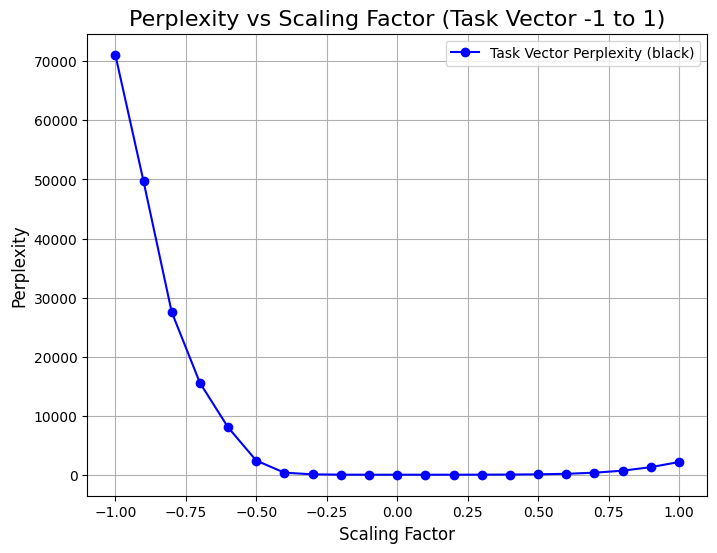

In [18]:
"""visaulize ppl"""
import matplotlib.pyplot as plt
import pandas as pd

# Load the saved CSV file into a DataFrame
ppl_df = pd.read_csv("neg_to_pos_ppl_results_black_1000.csv")

# Filter for scaling_factor >= -0.5
#filtered_df = ppl_df[ppl_df['scaling_factor'] >= -0.5]
filtered_df = ppl_df[(ppl_df["scaling_factor"] >= -0.4) & (ppl_df["scaling_factor"] <= 0.5)]

# Assuming the DataFrame has columns named 'scale' and 'perplexity'
scaling_factors_pos = ppl_df['scaling_factor'] #<---- needs to change to ppl_df to remove filter
perplexities_pos = ppl_df['ppl'] #<---- needs to change to ppl_df to remove filter

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(scaling_factors_pos, perplexities_pos, marker='o', color='b', label="Task Vector Perplexity (black_1000)")
plt.title("Perplexity vs Scaling Factor (Task Vector -1 to 1)", fontsize=16)
plt.xlabel("Scaling Factor", fontsize=12)
plt.ylabel("Perplexity", fontsize=12)
plt.grid(True)
plt.legend()

# Save the plot
plt.savefig("ppl_plot_black_1000_full_scale.png", dpi=300)

plt.show()

In [8]:
print(ppl_df)

    scaling_factor           ppl
0    -1.000000e+00  71112.750000
1    -9.000000e-01  49701.117188
2    -8.000000e-01  27560.115234
3    -7.000000e-01  15590.469727
4    -6.000000e-01   8040.101562
5    -5.000000e-01   2422.964355
6    -4.000000e-01    369.022705
7    -3.000000e-01     89.996918
8    -2.000000e-01     33.744591
9    -1.000000e-01     26.041969
10   -2.220446e-16     25.170399
11    1.000000e-01     25.738153
12    2.000000e-01     28.523466
13    3.000000e-01     35.700520
14    4.000000e-01     53.150101
15    5.000000e-01     92.936028
16    6.000000e-01    181.277740
17    7.000000e-01    367.477661
18    8.000000e-01    708.724609
19    9.000000e-01   1305.280640
20    1.000000e+00   2174.586182
